# Overview

This notebook is used to generate the training and test data sets used in the `sinusoidal-hypernets.ipynb` notebook. By keeping the notebooks separate, it makes `sinusoidal-hypernets.ipynb` more focused on the function and implementation of Hyper Networks in PyTorch.

This notebook will use `NumPy` to generate sine waves with added noise to use for the training data set. The test and validation data sets will be on true sine waves with no added noise. There are (2) test data sets and (2) validation data sets. Each will have (1) set with HyperNet inputs that are found in the training data set, and (1) set with HyperNet inputs that were not in the training data set. In this way, we see how well the trained HyperNetwork predicts a true sine wave when only being given noisy sine waves for a parameter set, and also how it predicts a true sine wave with parameters it has never seen.

In [ ]:
import numpy as np
import plotly.graph_objects as go

# Prep


The inputs to the HyperNet will be Amplitude and Frequency. These variables define the range and number of samples for the Amplitude and Frequency arrays.

In [ ]:
NUM_AMP_PTS = 15
MIN_AMP = 0.1
MAX_AMP = 0.9

NUM_FREQ_PTS = 15
MIN_FREQ = 2
MAX_FREQ = 10

These variables are used to create the sine waves for all data sets.

* `SEQ_LEN` and `PRED_LEN` are used to create input and prediction sequences for the LSTM TargetNet.
* `TRAIN_STEP` and `TEST_STEP` define how much to step forward between sequenced data.
    * In some demonstrations an `overlap` is defined instead.
* `ARRAY_LEN` and `NOISE_FACTOR` define the number of points in the sine waves and how many different noisy sine waves each HyperNet input set will have.
* Finally `NOISE_FACTOR` will define the max deviation for noise. This value is multiplied by Amplitude.

In [ ]:
SEQ_LEN = 200
PRED_LEN = 1
TRAIN_STEP = 5
TEST_STEP = 1
ARRAY_LEN = 1000
ARRAYS_PER_PARAM_SET = 15

NOISE_FACTOR = 0.1

These define the number of arrays in:
* The ***t***est data set with HyperNet ***t***raining parameters
* The ***t***est data set with ***n***ew HyperNet parameters
* The ***v***alidation data set with HyperNet ***t***raining parameters
* The ***v***alidation data set with ***n***ew HyperNet parameters

In [ ]:
NTTP = 5
NTNP = 5
NVTP = 5
NVNP = 5

Finally we define the saved filenames. Since we are using NumPy to save compressed data, the file extension must be `.npz`.

In [ ]:
TRAIN_FILE = "sinusoidal-train.npz"
TEST1_FILE = "sinusoidal-test-tp.npz"
TEST2_FILE = "sinusoidal-test-np.npz"
VAL_1_FILE = "sinusoidal-val-tp.npz"
VAL_2_FILE = "sinusoidal-val-np.npz"

# Base Arrays

Create the time array used in the creation of all sine waves. Also create the sample arrays for Amplitude and Frequency to create the HyperNet input arrays.

In [ ]:
A = np.linspace(MIN_AMP, MAX_AMP, NUM_AMP_PTS)
F = np.linspace(MIN_FREQ, MAX_FREQ, NUM_FREQ_PTS)
t = np.linspace(0, 2 * np.pi, ARRAY_LEN)

# Sequencing

This function will take a sine wave (true or noisy) and convert it into LSTM sequences for later batching.

In [ ]:
def sequence_sine(sine_: np.ndarray, step: int) -> tuple[np.ndarray]:
    seqs, preds, start = None, None, 0
    for _ in range(int((ARRAY_LEN - SEQ_LEN - PRED_LEN) / step) + 1):
        seq = sine_[start : start + SEQ_LEN].reshape(1, SEQ_LEN, 1)
        pred = sine_[start + SEQ_LEN : start + SEQ_LEN + PRED_LEN].reshape(
            1,
        )
        seqs = seq if seqs is None else np.vstack([seqs, seq])
        preds = pred if preds is None else np.vstack([preds, pred])
        start += step
    return seqs, preds

# Training Arrays

Here we create the noisy sine waves that are used for the training data set. We loop over the Amplitude and Frequency sampling arrays and record them separately from the sine wave data. Then we create and sequence the noisy sine waves and then save the arrays in a dictionary.

Once all noisy sine waves are created and sequenced, we save the list of dictionaries of arrays to a compressed NumPy file.

In [ ]:
train_ds, count = [], 0
for amp in A:
    for f in F:
        hyper_params = np.array([amp, f])
        for i in range(ARRAYS_PER_PARAM_SET):
            sine = amp * np.sin(f * t) + (amp * NOISE_FACTOR * (np.random.rand(*t.shape) - 0.5))
            seqs, preds = sequence_sine(sine, TRAIN_STEP)
            train_ds.append({"hx": hyper_params, "tx": seqs, "tyhat": preds})
            count += 1
            print(f"Created and sequenced {count} arrays", end="\r")

print(f"Created and sequenced {count} arrays")
print(f"Writing training data set to {TRAIN_FILE}")
np.savez_compressed(TRAIN_FILE, train_ds)

Created and sequenced 3375 arrays
Writing training data set to sinusoidal-train.npz


# Array Inspection

To make sure that the noisy level is at the value we want, we will plot the last sine wave that was created. We don't want the noise to be so high that the data is no longer recognizable as a sine wave, but not so small that the difference from a true sine wave is negligible.

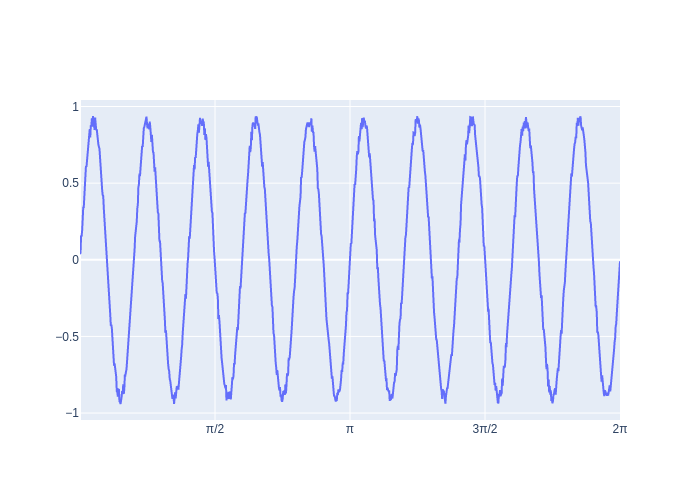

In [ ]:
# inspect the last sine wave
fig = go.Figure()
fig.update_layout(
    xaxis={
        "tickmode": "array",
        "tickvals": [0.5 * np.pi, np.pi, 1.5 * np.pi, 2 * np.pi],
        "ticktext": ["π/2", "π", "3π/2", "2π"],
    },
)
fig.add_trace(
    go.Scatter(
        x=t,
        y=sine,
    )
)
fig.show()

# Test and Validation 1

Now we create the test and validation data set with HyperNet input values that were found in the training data set created above.

We randomly select different values of Amplitude and Frequency and create a true sine wave representation for those values.

For a true representation of testing and validating our model, there can be no values in one data set that are also found in the other.

Once all arrays are created and sequenced, we save them to the file names defined at the beginning of the notebook.

In [ ]:
A_sels, F_sels, test_1, val_1 = [], [], [], []

for _ in range(NTTP):

    # select random A and F from HyperNet training parameters
    sel_A = np.random.randint(0, len(A) - 1, (100,))
    sel_F = np.random.randint(0, len(F) - 1, (100,))
    sel_A = [x for x in sel_A if x not in A_sels][0]
    sel_F = [x for x in sel_F if x not in F_sels][0]
    A_sels.append(sel_A)
    F_sels.append(sel_F)

    # create tensors
    hyper_params = np.array([A[sel_A], F[sel_F]])
    sine = A[sel_A] * np.sin(F[sel_F] * t)

    # sequence sine wave array
    seqs, preds = sequence_sine(sine, TRAIN_STEP)

    # append data set
    test_1.append({"hx": hyper_params, "tx": seqs, "tyhat": preds})

for _ in range(NVTP):

    # select random A and F from training HyperNet Parameters
    sel_A = np.random.randint(0, len(A) - 1, (100,))
    sel_F = np.random.randint(0, len(F) - 1, (100,))
    sel_A = [x for x in sel_A if x not in A_sels][0]
    sel_F = [x for x in sel_F if x not in F_sels][0]
    A_sels.append(sel_A)
    F_sels.append(sel_F)

    # create tensors
    hyper_params = np.array([A[sel_A], F[sel_F]])
    sine = A[sel_A] * np.sin(F[sel_F] * t)

    # sequence sine wave array
    seqs, preds = sequence_sine(sine, TEST_STEP)

    # append data set
    val_1.append({"hx": hyper_params, "tx": seqs, "tyhat": preds})

np.savez_compressed(TEST1_FILE, test_1)
np.savez_compressed(VAL_1_FILE, val_1)

# Test and Validation 2

Now we create the test and validation data sets for values that were not included in the training data set. We use NumPy's `rand()` funnction to generate 1000 different values and select the first one that was not in the training data set and not already selected previously.

Once all arrays are created and sequenced, we save them to the file names defined at the beginning of the notebook.

In [ ]:
min_A, max_A = min(A), max(A)
min_F, max_F = min(F), max(F)

A_sels, F_sels, test_2, val_2 = [], [], [], []

for _ in range(NTNP):

    # select random A and F not in HyperNet training parameters
    sel_A = np.random.rand(1000)
    sel_F = np.random.rand(1000) * max_F
    sel_A = [x for x in sel_A if x not in A and x not in A_sels and min_A < x < max_A][0]
    sel_F = [x for x in sel_F if x not in F and x not in F_sels and min_F < x < max_F][0]
    A_sels.append(sel_A)
    F_sels.append(sel_F)

    # create tensors
    hyper_params = np.array([sel_A, sel_F])
    sine = sel_A * np.sin(sel_F * t)

    # sequence sine wave array
    seqs, preds = sequence_sine(sine, TRAIN_STEP)

    # append data set
    test_2.append({"hx": hyper_params, "tx": seqs, "tyhat": preds})

for _ in range(NVNP):

    # select random A and F not in HyperNet training parameters
    sel_A = np.random.rand(1000)
    sel_F = np.random.rand(1000) * max_F
    sel_A = [x for x in sel_A if x not in A and x not in A_sels and min_A < x < max_A][0]
    sel_F = [x for x in sel_F if x not in F and x not in F_sels and min_F < x < max_F][0]
    A_sels.append(sel_A)
    F_sels.append(sel_F)

    # create tensors
    hyper_params = np.array([sel_A, sel_F])
    sine = sel_A * np.sin(sel_F * t)

    # sequence sine wave array
    seqs, preds = sequence_sine(sine, TEST_STEP)

    # append data set
    val_2.append({"hx": hyper_params, "tx": seqs, "tyhat": preds})

np.savez_compressed(TEST2_FILE, test_2)
np.savez_compressed(VAL_2_FILE, val_2)